In [10]:
from load_data import get_sample
from PIL import Image
from stablediffusion import StableDiffusion
import torch
from vision_encoder import vision_encoder
from llm import ClipCaptionModel, generate2
import os
from transformers import GPT2Tokenizer
import numpy as np
from fashion_clip.fashion_clip import FashionCLIP

sd = StableDiffusion()
encoder = vision_encoder()
fclip = FashionCLIP('fashion-clip')

In [3]:
prefix_length = 10
current_directory = os.getcwd()
save_path = os.path.join(current_directory, "saved_models")
os.makedirs(save_path, exist_ok=True)

CPU = torch.device('cpu')
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = ClipCaptionModel(prefix_length)
model_path = os.path.join(save_path, 'fashion.pt')
model.load_state_dict(torch.load(model_path, map_location=CPU)) 
model = model.eval() 
model = model.to(device)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

Short jumper in a soft, loose knit with a knot detail at the front, dropped shoulders, long sleeves and ribbing around the neckline and cuffs.


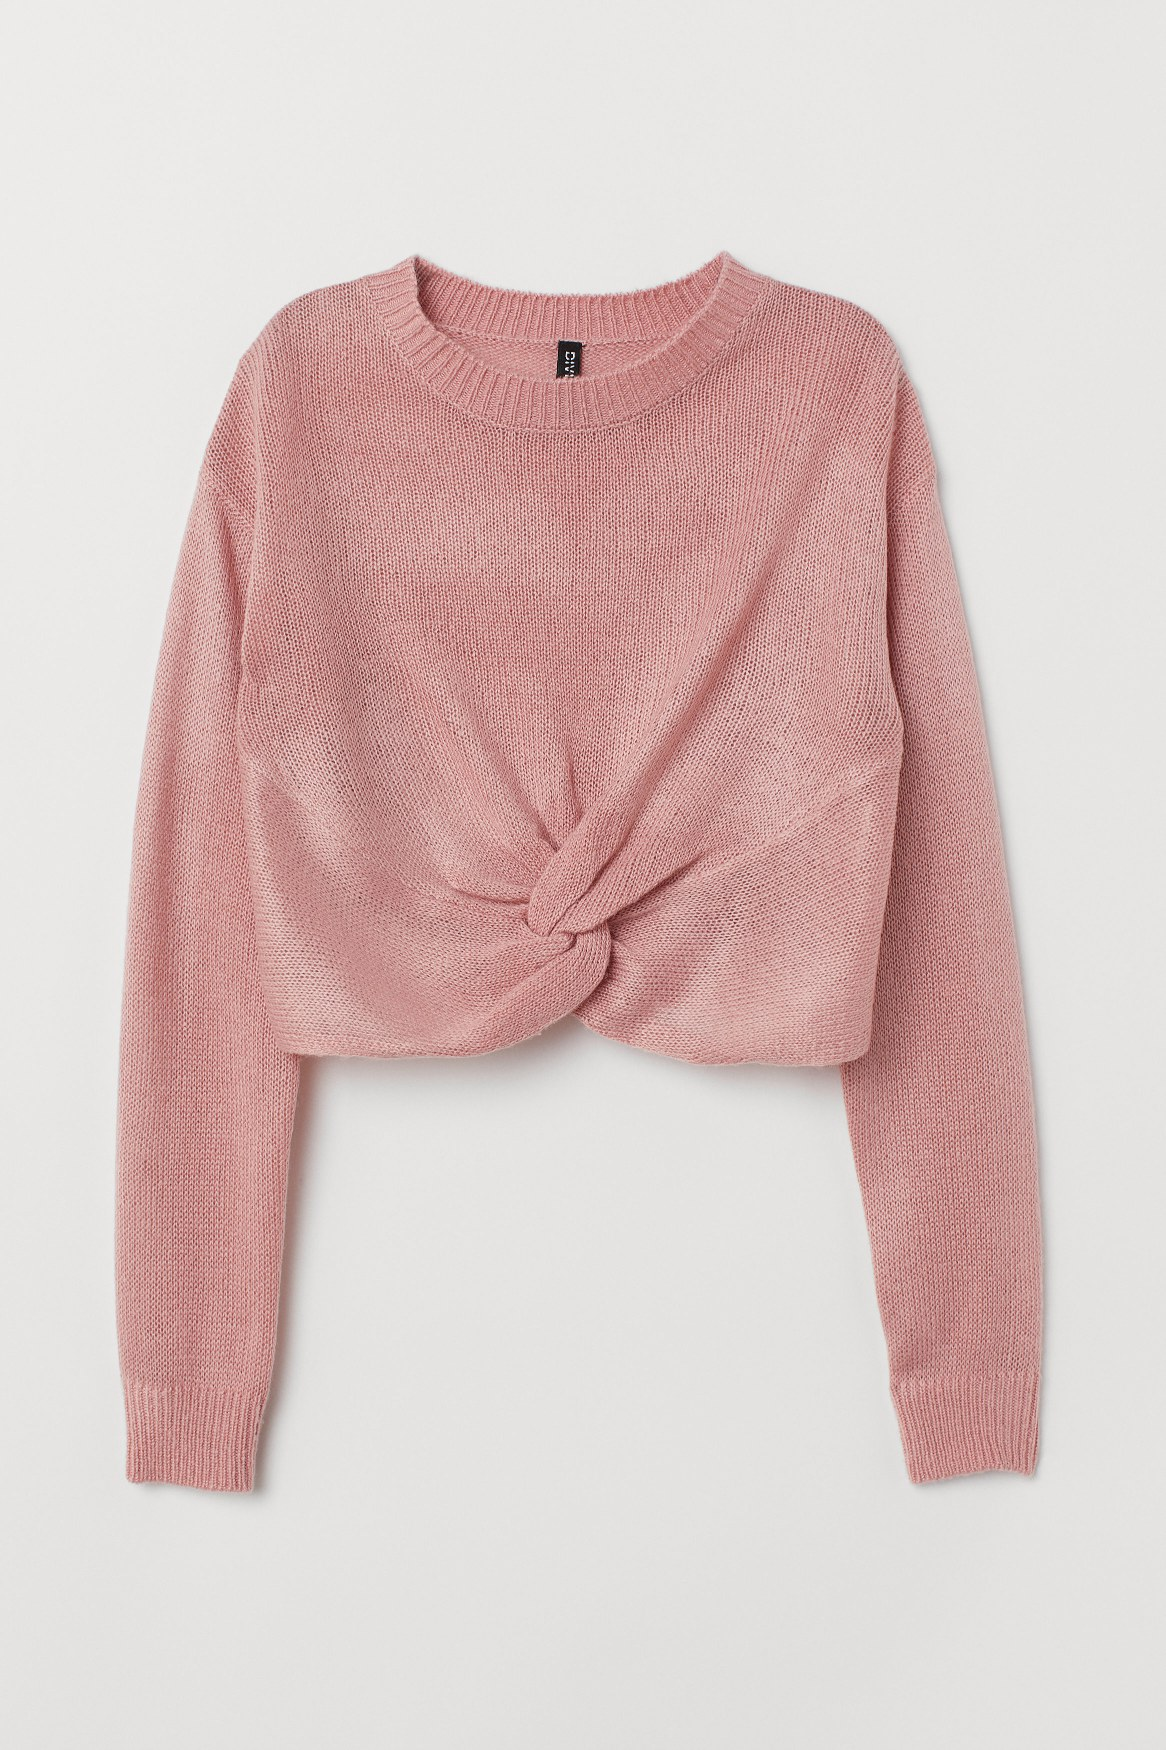

100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

Long-sleeved jumper in a soft, fine knit with a ribbed stand-up collar and ribbing around the neckline, cuffs and hem.


  0%|          | 0/26 [00:00<?, ?it/s]

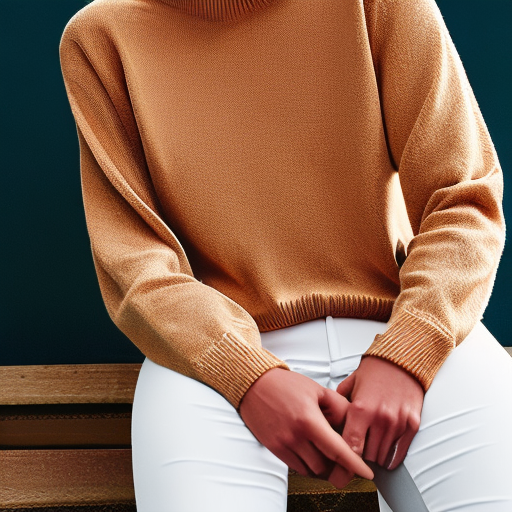

1it [00:00, 10.82it/s]
1it [00:00, 31.11it/s]

<built-in method type of Tensor object at 0x7f68566eaca0> torch.Size([1, 512])
tensor(0.2213, device='cuda:0')


In [14]:
pil_image, row = get_sample()
print(row['detail_desc'])
display(pil_image)

image_embeddings = fclip.encode_images([pil_image], batch_size=1)
image_embeddings = image_embeddings / np.linalg.norm(image_embeddings, ord=2, axis=-1, keepdims=True)
image_embeddings = torch.tensor(image_embeddings).to(device)
        
prefix_embed = model.clip_project(image_embeddings).reshape(1, prefix_length, -1)
out = generate2(model, tokenizer, embed=prefix_embed)
print(out)
prompt = [out]
sd.requires_grad_(False) # Note: Running out of memory if require grad

output = sd.forward(prompt)
output  = (output.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
output = Image.fromarray(output)
output.show()
loss = encoder.calc_loss([pil_image], [output])
print(loss)